Reading mobley_cavity.txt
Dont have ammonia in BEM
Dont have hydrogen_sulfide in BEM
Reading mobley_es.txt
Dont have ammonia in BEM
Dont have hydrogen_sulfide in BEM
Reading mobley_dG_total.txt
Dont have hydrogen_sulfide in BEM
Reading mobley_exp.txt
Dont have ammonia in BEM
Dont have hydrogen_sulfide in BEM
Reading slic_es.txt
Dont have hydrogen_sulfide in BEM
Cant find Li
Cant find Na
Cant find K
Cant find Rb
Cant find Cs
Cant find F
Cant find Cl
Cant find Br
Cant find I
Number of failed tests: 2
Number of molecules in correlation: 497


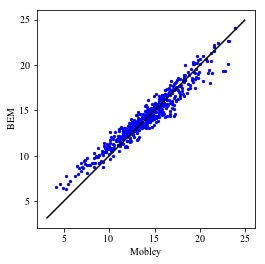

In [18]:
import numpy
from matplotlib import pyplot
%matplotlib inline

def read_file(filename, N, bem_es):
    
    print('Reading '+filename)
    out_array = numpy.zeros(N, dtype=float)

    file_in = open(filename,'r')
    for line in file_in:
        line = line.split()
        mol_name = line[0]
        mol_index = numpy.where(mol_name==names)[0]
        if len(mol_index)==0: 
            print ('Cant find '+ mol_name)
        elif bem_es[mol_index]<1e-12:
            print ('Dont have '+mol_name+' in BEM')
        else:
            out_array[mol_index] = float(line[1])
    file_in.close()

    return out_array

bem_es = numpy.loadtxt('energy_bem_phi107_eps665.txt')#*1.009

#bem_es = numpy.loadtxt('energy_bem_phi12.txt')#*30./5.

#test_charge = numpy.loadtxt('test_charge.txt')
bem_lj_r14 = numpy.loadtxt('vdw_energy_d20.txt')
bem_lj_r28 = numpy.loadtxt('vdw_energy_r28.txt')

bem_lj_layer = bem_lj_r14 - bem_lj_r28

bem_lj = bem_lj_r28 + bem_lj_layer*1.5

bem = bem_es + bem_lj

mobley = numpy.loadtxt('mobley_results_clean.txt')
names = numpy.loadtxt('actually_all_names.txt', dtype=str)
names_michael = numpy.loadtxt('actually_all_names_michael.txt', dtype=str)
volumes = numpy.loadtxt('volumes_stern_fix.txt')
areas = numpy.loadtxt('areas_stern_fix.txt')

mobley_cav = read_file('mobley_cavity.txt', len(mobley), bem_es)
mobley_es = read_file('mobley_es.txt', len(mobley), bem_es)
mobley_total = read_file('mobley_dG_total.txt', len(mobley), bem_es)
mobley_exp = read_file('mobley_exp.txt', len(mobley), bem_es)
slic_es = read_file('slic_es.txt', len(mobley), bem_es)


mobley_disp = mobley - mobley_cav

michael_array = []
for i in range(len(names_michael)):
    if names_michael[i][0]=='_':
        names_michael[i] = names_michael[i][1:]
        michael_array.append(i)
michael_array = numpy.array(michael_array) 
    
smiles_filename = 'mobley_test/smiles/smiles.txt'
smiles = numpy.chararray(len(mobley), itemsize=30)
i=0
with open(smiles_filename,'r') as smiles_file:
    for line in smiles_file:
        line = line.split()
        smiles[i] = line[-1]
        i += 1

index_clean = numpy.where(abs(bem)>1e-12)[0]
index_clean_mobley = numpy.where(numpy.logical_and(mobley_cav>1e-12, numpy.absolute(slic_es)>1e-12))[0]


#index_clean_mobley = michael_array

print ('Number of failed tests: %i'%(len(bem)-len(index_clean)))

fig,ax = pyplot.subplots()
#ax.scatter(mobley[index_clean], bem[index_clean], s=5)
ax.scatter(mobley_cav[index_clean_mobley], bem_es[index_clean_mobley], s=5, c='b')

#bem_es2 = numpy.loadtxt('energy_bem_phi10_eps62.txt')#*30./5.
#ax.scatter(mobley_cav[index_clean_mobley], bem_es2[index_clean_mobley], s=5, c='r')

#bem_es3 = numpy.loadtxt('energy_bem_phi10.txt')*31.8/5.
#ax.scatter(mobley_cav[index_clean_mobley], bem_es3[index_clean_mobley], s=5, c='k')


#ax.scatter(mobley_disp[index_clean], bem_lj[index_clean], s=5)
#print (mobley_cav)
#print (bem_es)


lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k')

print ("Number of molecules in correlation: %i"%len(index_clean_mobley))

ax.set_aspect('equal')
#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('Mobley')
ax.set_ylabel('BEM')
fig.savefig('comparison.pdf')
#fig.show()

In [19]:
index_fail = numpy.where(abs(bem)<1e-12)[0]
index_fail

array([229, 341])

In [20]:
names[229], names[341]

('ammonia', 'hydrogen_sulfide')

In [21]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


bem_c = bem_es[index_clean_mobley]
mobley_c = mobley_cav[index_clean_mobley]
names_c = names[index_clean_mobley]
volumes_c = volumes[index_clean_mobley]
areas_c = areas[index_clean_mobley]
#test_charge_c = test_charge[index_clean]

smiles_c = []
for i in index_clean_mobley:
    smiles_c.append(str(smiles[i], encoding='utf-8'))
#smiles_c = str(smiles[index_clean], encoding='utf-8') 

key = '_1_'
key_true = []# numpy.chararray(len(bem_c), itemsize=10)
#key_true[:] = "blue"
for i in range(len(bem_c)):
    if key in names_c[i]:
        key_true.append("red")
    else:
        key_true.append("blue")

trace = go.Scatter(
            x = mobley_c,
            y = bem_c,
            text = names_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color=key_true),
#                        opacity=0.6, color=areas_c),
            hoverinfo = 'text')


max_val = numpy.max(mobley_c)
ref = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([0,max_val]),
                  mode = 'lines'
                )

ref2 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([1,max_val+1]),
                  mode = 'lines'
                )
ref3 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([-1,max_val-1]),
                  mode = 'lines'
                )

data = [trace, ref, ref2, ref3]
    
layout= go.Layout(
    title= 'Cavity energy',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Explicit',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'BEM',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#Cross correlation
correl = numpy.corrcoef(bem_c, mobley_c)
print ('Correlation coeff bem: ')
print (correl)

rmsd = numpy.sqrt(numpy.sum(numpy.abs(bem_c-mobley_c)**2)/len(bem_c))
print ('RMSD')
print(rmsd)

mue = numpy.sum(numpy.abs(bem_c-mobley_c))/len(bem_c)
print ('MUE')
print (mue)

Correlation coeff bem: 
[[1.         0.96554845]
 [0.96554845 1.        ]]
RMSD
0.984249700825422
MUE
0.7766566124535137


In [22]:
bem_c = bem_lj[index_clean_mobley]
mobley_c = mobley_disp[index_clean_mobley]

key = '_1_'
key_true = []# numpy.chararray(len(bem_c), itemsize=10)
#key_true[:] = "blue"
for i in range(len(bem_c)):
    if key in names_c[i]:
        key_true.append("red")
    else:
        key_true.append("blue")

trace = go.Scatter(
            x = mobley_c,
            y = bem_c,
            text = names_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color=key_true),
#                        opacity=0.6, color=areas_c),
            hoverinfo = 'text')


min_val = numpy.min(mobley_c)
ref = go.Scatter( x = numpy.array([min_val,0]),
                  y = numpy.array([min_val,0]),
                  mode = 'lines'
                )

ref2 = go.Scatter( x = numpy.array([min_val,0]),
                  y = numpy.array([min_val+1,1]),
                  mode = 'lines'
                )
ref3 = go.Scatter( x = numpy.array([min_val,0]),
                  y = numpy.array([min_val-1,-1]),
                  mode = 'lines'
                )

data = [trace, ref, ref2, ref3]
    
layout= go.Layout(
    title= 'Dispersion energy',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Explicit',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'BEM',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#Cross correlation
correl = numpy.corrcoef(bem_c, mobley_c)
print ('Correlation coeff bem: ')
print (correl)

rmsd = numpy.sqrt(numpy.sum(numpy.abs(bem_c-mobley_c)**2)/len(bem_c))
print ('RMSD')
print(rmsd)

mue = numpy.sum(numpy.abs(bem_c-mobley_c))/len(bem_c)
print ('MUE')
print (mue)

Correlation coeff bem: 
[[1.         0.97662309]
 [0.97662309 1.        ]]
RMSD
0.9728143674546956
MUE
0.7551860181085707


In [23]:
bem_c = bem[index_clean_mobley]
mobley_c = mobley[index_clean_mobley]

key = '_1_'
key_true = []# numpy.chararray(len(bem_c), itemsize=10)
#key_true[:] = "blue"
for i in range(len(bem_c)):
    if key in names_c[i]:
        key_true.append("red")
    else:
        key_true.append("blue")

trace = go.Scatter(
            x = mobley_c,
            y = bem_c,
            text = names_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color=key_true),
#                        opacity=0.6, color=areas_c),
            hoverinfo = 'text')


max_val = numpy.max(mobley_c)
ref = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([0,max_val]),
                  mode = 'lines'
                )

ref2 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([1,max_val+1]),
                  mode = 'lines'
                )
ref3 = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([-1,max_val-1]),
                  mode = 'lines'
                )

data = [trace, ref, ref2, ref3]
    
layout= go.Layout(
    title= 'Total Nonpolar Solvation Energy',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Explicit',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'BEM',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#Cross correlation
correl = numpy.corrcoef(bem_c, mobley_c)
print ('Correlation coeff bem: ')
print (correl)

rmsd = numpy.sqrt(numpy.sum(numpy.abs(bem_c-mobley_c)**2)/len(bem_c))
print ('RMSD')
print(rmsd)

mue = numpy.sum(numpy.abs(bem_c-mobley_c))/len(bem_c)
print ('MUE')
print (mue)

Correlation coeff bem: 
[[1.         0.88151999]
 [0.88151999 1.        ]]
RMSD
0.4168222661287833
MUE
0.28907591661133136


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff dGcav vs dGvdw
[[ 1.         -0.95934989]
 [-0.95934989  1.        ]]


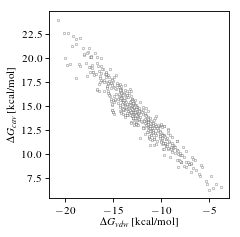

In [24]:
from matplotlib import pyplot
from matplotlib import rc

#rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)
#pyplot.rcParams['font.family'] = 'serif'
#pyplot.rcParams['font.serif'] = ['Times New Roman']

fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)
ax.scatter(bem_lj[index_clean_mobley], bem_es[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.set_xlabel('$\Delta G_{vdw}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('$\Delta G_{cav}$ [kcal/mol]', fontname='serif')
ax.set_aspect('equal')

#ax.set_xlim(lims)
#ax.set_ylim(lims)
pyplot.subplots_adjust(left=0.21,bottom=0.10,right=0.96,top=0.99)
fig.savefig('dGcav_dGvdw.pdf')
fig.show()
correl = numpy.corrcoef(bem_es[index_clean], bem_lj[index_clean])
print ('Correlation coeff dGcav vs dGvdw')
print (correl)


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for dGcav
[[1.         0.96554845]
 [0.96554845 1.        ]]


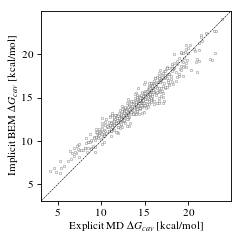

In [25]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(mobley_cav[index_clean_mobley], bem_es[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

ax.plot([lims[0],lims[1]],[lims[0],lims[1]], c='k', marker='',ls='--',lw=0.5)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Explicit MD $\\Delta G_{cav}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('Implicit BEM $\\Delta G_{cav}$ [kcal/mol]', fontname='serif')
pyplot.subplots_adjust(left=0.17,bottom=0.14,right=0.96,top=0.99)
fig.savefig('dGcav.pdf')
fig.show()
correl = numpy.corrcoef(bem_es[index_clean_mobley], mobley_cav[index_clean_mobley])
print ('Correlation coeff for dGcav')
print (correl)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for dGlj
[[1.         0.97662309]
 [0.97662309 1.        ]]


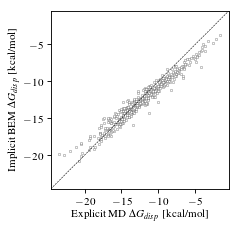

In [26]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(mobley_disp[index_clean_mobley], bem_lj[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.plot([lims[0],lims[1]],[lims[0],lims[1]], c='k', marker='',ls='--',lw=0.5)
ax.set_xlabel('Explicit MD $\\Delta G_{disp}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('Implicit BEM $\\Delta G_{disp}$ [kcal/mol]', fontname='serif')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
pyplot.subplots_adjust(left=0.22,bottom=0.09,right=0.96,top=0.99)
fig.savefig('dGdisp.pdf')
fig.show()
correl = numpy.corrcoef(bem_lj[index_clean_mobley], mobley_disp[index_clean_mobley])
print ('Correlation coeff for dGlj')
print (correl)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for dGnonpolar
[[1.         0.88151999]
 [0.88151999 1.        ]]


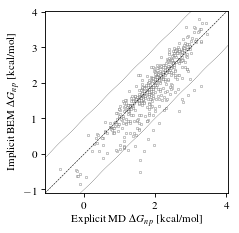

In [27]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(mobley[index_clean_mobley], bem[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.plot([lims[0],lims[1]],[lims[0],lims[1]], c='k', marker='',ls='--',lw=0.5)
ax.plot([lims[0]+1,lims[1]+1],[lims[0],lims[1]], c='k', marker='',ls=':',lw=0.5)
ax.plot([lims[0]-1,lims[1]-1],[lims[0],lims[1]], c='k', marker='',ls=':',lw=0.5)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
ax.set_xlabel('Explicit MD $\\Delta G_{np}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('Implicit BEM $\\Delta G_{np}$ [kcal/mol]', fontname='serif')
pyplot.subplots_adjust(left=0.2,bottom=0.05,right=0.96,top=0.99)
fig.savefig('dGnp.pdf')
fig.show()
correl = numpy.corrcoef(bem[index_clean_mobley], mobley[index_clean_mobley])
print ('Correlation coeff for dGnonpolar')
print (correl)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for slic_es
[[1.         0.97445311]
 [0.97445311 1.        ]]
RMSD
0.7237396319449341
MUE
0.46934640845070413


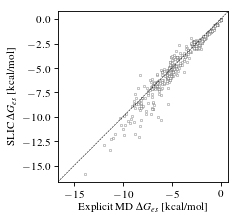

In [28]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)
#from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

ax.scatter(mobley_es[index_clean_mobley], slic_es[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.plot([lims[0],lims[1]],[lims[0],lims[1]], c='k', marker='',ls='--',lw=0.5)
ax.set_xlabel('Explicit MD $\\Delta G_{es}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('SLIC $\\Delta G_{es}$ [kcal/mol]', fontname='serif')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
pyplot.subplots_adjust(left=0.25,bottom=0.09,right=0.96,top=0.99)
fig.savefig('dGes.pdf')
fig.show()
correl = numpy.corrcoef(slic_es[index_clean_mobley], mobley_es[index_clean_mobley])
print ('Correlation coeff for slic_es')
print (correl)

rmsd = numpy.sqrt(numpy.sum(numpy.abs(slic_es[index_clean_mobley]-mobley_es[index_clean_mobley])**2)/len(slic_es[index_clean_mobley]))
print ('RMSD')
print(rmsd)

mue = numpy.sum(numpy.abs(slic_es[index_clean_mobley]-mobley_es[index_clean_mobley]))/len(slic_es[index_clean_mobley])
print ('MUE')
print (mue)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for dG_total
[[1.         0.96979682]
 [0.96979682 1.        ]]
RMSD
0.9111164158444991
MUE
0.6427158633404428


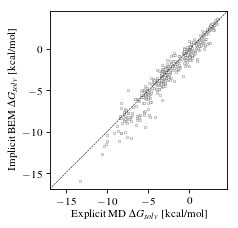

In [29]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

dG_total_implicit = bem_es + slic_es + bem_lj
ax.scatter(mobley_total[index_clean_mobley], dG_total_implicit[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.plot([lims[0],lims[1]],[lims[0],lims[1]], c='k', marker='',ls='--',lw=0.5)
ax.set_xlabel('Explicit MD $\\Delta G_{solv}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('Implicit BEM $\\Delta G_{solv}$ [kcal/mol]', fontname='serif')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
pyplot.subplots_adjust(left=0.22,bottom=0.09,right=0.96,top=0.99)
fig.savefig('dGtotal.pdf')
fig.show()
correl = numpy.corrcoef(dG_total_implicit[index_clean_mobley], mobley_total[index_clean_mobley])
print ('Correlation coeff for dG_total')
print (correl)
rmsd = numpy.sqrt(numpy.sum(numpy.abs(dG_total_implicit[index_clean_mobley]-mobley_total[index_clean_mobley])**2)/len(dG_total_implicit[index_clean_mobley]))
print ('RMSD')
print(rmsd)

mue = numpy.sum(numpy.abs(dG_total_implicit[index_clean_mobley]-mobley_total[index_clean_mobley]))/len(dG_total_implicit[index_clean_mobley])
print ('MUE')
print (mue)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff with experimental dG
[[1.         0.92558971]
 [0.92558971 1.        ]]
RMSD
1.3335245713466335
MUE
1.0213035809441076


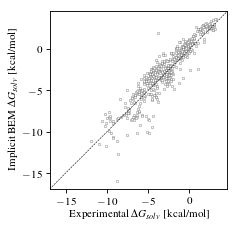

In [30]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

dG_total_implicit = bem_es + slic_es + bem_lj
ax.scatter(mobley_exp[index_clean_mobley], dG_total_implicit[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.plot([lims[0],lims[1]],[lims[0],lims[1]], c='k', marker='',ls='--',lw=0.5)
ax.set_xlabel('Experimental $\\Delta G_{solv}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('Implicit BEM $\\Delta G_{solv}$ [kcal/mol]', fontname='serif')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
pyplot.subplots_adjust(left=0.22,bottom=0.09,right=0.96,top=0.99)
fig.savefig('dGexp.pdf')
fig.show()
correl = numpy.corrcoef(dG_total_implicit[index_clean_mobley], mobley_exp[index_clean_mobley])
print ('Correlation coeff with experimental dG')
print (correl)
rmsd = numpy.sqrt(numpy.sum(numpy.abs(dG_total_implicit[index_clean_mobley]-mobley_exp[index_clean_mobley])**2)/len(dG_total_implicit[index_clean_mobley]))
print ('RMSD')
print(rmsd)

mue = numpy.sum(numpy.abs(dG_total_implicit[index_clean_mobley]-mobley_exp[index_clean_mobley]))/len(dG_total_implicit[index_clean_mobley])
print ('MUE')
print (mue)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff of MD with experimental dG
[[1.         0.94173918]
 [0.94173918 1.        ]]
RMSD
1.261680078196652
MUE
1.0360965794768613


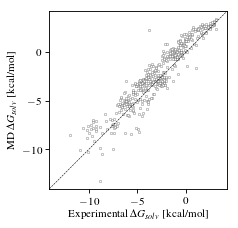

In [31]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

dG_total_implicit = bem_es + slic_es + bem_lj
ax.scatter(mobley_exp[index_clean_mobley], mobley_total[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
ax.plot([lims[0],lims[1]],[lims[0],lims[1]], c='k', marker='',ls='--',lw=0.5)
ax.set_xlabel('Experimental $\\Delta G_{solv}$ [kcal/mol]', fontname='serif')
ax.set_ylabel('MD $\\Delta G_{solv}$ [kcal/mol]', fontname='serif')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
pyplot.subplots_adjust(left=0.22,bottom=0.09,right=0.96,top=0.99)
fig.savefig('dGexpMD.pdf')
fig.show()
correl = numpy.corrcoef(mobley_total[index_clean_mobley], mobley_exp[index_clean_mobley])
print ('Correlation coeff of MD with experimental dG')
print (correl)
rmsd = numpy.sqrt(numpy.sum(numpy.abs(mobley_total[index_clean_mobley]-mobley_exp[index_clean_mobley])**2)/len(dG_total_implicit[index_clean_mobley]))
print ('RMSD')
print(rmsd)

mue = numpy.sum(numpy.abs(mobley_total[index_clean_mobley]-mobley_exp[index_clean_mobley]))/len(dG_total_implicit[index_clean_mobley])
print ('MUE')
print (mue)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for with area
[[1.         0.99891654]
 [0.99891654 1.        ]]


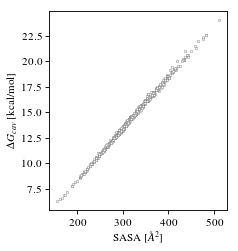

In [32]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(areas[index_clean_mobley], bem_es[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

#ax.set_xlim(lims)
#ax.set_ylim(lims)
#ax.set_aspect('equal')
ax.set_xlabel('SASA [$\AA^2$]', fontname='serif')
ax.set_ylabel('$\\Delta G_{cav}$ [kcal/mol]', fontname='serif')
pyplot.subplots_adjust(left=0.22,bottom=0.16,right=0.96,top=0.99)
fig.savefig('dG_cav_area.pdf')
fig.show()
correl = numpy.corrcoef(bem_es[index_clean_mobley], areas[index_clean_mobley])
print ('Correlation coeff for with area')
print (correl)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for with area
[[ 1.        -0.9507754]
 [-0.9507754  1.       ]]


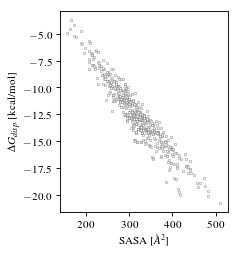

In [33]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(areas[index_clean_mobley], bem_lj[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SASA [$\AA^2$]', fontname='serif')
ax.set_ylabel('$\\Delta G_{disp}$ [kcal/mol]', fontname='serif')
pyplot.subplots_adjust(left=0.26,bottom=0.15,right=0.96,top=0.99)
fig.savefig('dG_lj_area.pdf')
fig.show()
correl = numpy.corrcoef(bem_lj[index_clean_mobley], areas[index_clean_mobley])
print ('Correlation coeff for with area')
print (correl)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Correlation coeff for with area
[[1.         0.23094048]
 [0.23094048 1.        ]]


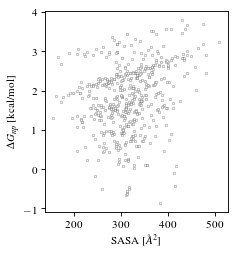

In [34]:
fig,ax = pyplot.subplots(figsize=(3,3), dpi=80)

ax.scatter(areas[index_clean_mobley], bem[index_clean_mobley], s=5, c='w', edgecolors='k', lw=0.2)
lims = [
        numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

#ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.set_xlabel('SASA [$\AA^2$]',fontname='serif')
ax.set_ylabel('$\\Delta G_{np}$ [kcal/mol]',fontname='serif')
pyplot.subplots_adjust(left=0.2,bottom=0.15,right=0.96,top=0.99)
fig.savefig('dG_area.pdf')
fig.show()
correl = numpy.corrcoef(bem[index_clean_mobley], areas[index_clean_mobley])
print ('Correlation coeff for with area')
print (correl)

In [35]:
file_imp = open('implicit_data.txt','w')
file_exp = open('explicit_data.txt','w')
file_imp.write('IUPAC, SMILES, dGes, dGcav, dGdisp, dGexper, SASA, Vol\n')
file_exp.write('IUPAC, SMILES, dGes, dGcav, dGdisp, dGexper \n')
for i in index_clean_mobley:
    file_imp.write(names[i]+', ' + str(smiles[i], encoding='utf-8') + ', %1.4f, %1.4f, %1.4f, %1.4f, %1.4f, %1.4f\n'%(slic_es[i], bem_es[i], bem_lj[i], mobley_exp[i], areas[i], volumes[i]))
    file_exp.write(names[i]+', ' + str(smiles[i], encoding='utf-8') + ', %1.4f, %1.4f, %1.4f, %1.4f\n'%(mobley_es[i], mobley_cav[i], mobley_disp[i], mobley_exp[i]))

file_imp.close()
file_exp.close()